# Transfer Learning for Colposcopy Image Classification

Using InceptionV3 with advanced training strategy and detailed analysis

In [224]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import numpy as np
from collections import defaultdict
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [225]:
# Define parameters
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3
BATCH_SIZE = 32
IMAGE_PATH = 'data/sorted'

In [226]:
# Load training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    'data/sorted',
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

# Load validation dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    'data/sorted',
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 909 files belonging to 11 classes.
Using 728 files for training.
Found 909 files belonging to 11 classes.
Using 181 files for validation.


In [227]:
class_names = train_dataset.class_names

# Analyze class distribution
class_counts = defaultdict(int)
for images, labels in train_dataset:
    labels = labels.numpy()
    for label in labels:
        class_name = class_names[label]
        class_counts[class_name] += 1

print("\nTraining set class counts:")
for class_name in class_names:
    count = class_counts.get(class_name, 0)
    print(f"{class_name}: {count}")


Training set class counts:
0: 58
1: 96
10: 82
2: 113
3: 17
4: 54
5: 43
6: 32
7: 30
8: 70
9: 133


2024-12-05 12:55:48.192788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


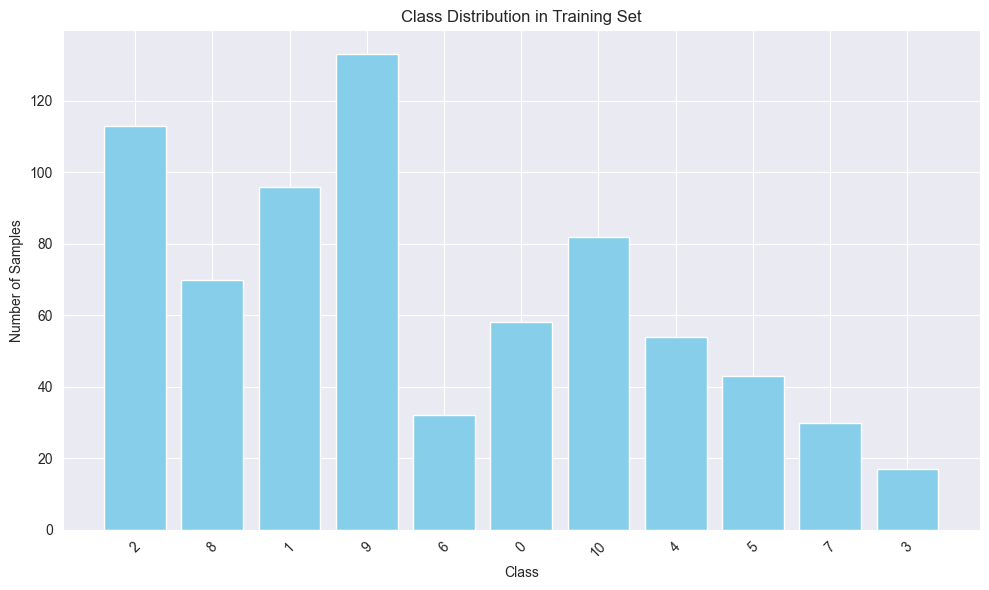

In [228]:
# Plot class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Set')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [229]:
# Calculate class weights
total_samples = sum(class_counts.values())
class_weights = {}

for i, class_name in enumerate(class_names):
    class_weights[i] = total_samples / (len(class_names) * class_counts[class_name])

print("\nClass weights:")
print(class_weights)


Class weights:
{0: 1.141065830721003, 1: 0.6893939393939394, 2: 0.8070953436807096, 3: 0.585679806918745, 4: 3.893048128342246, 5: 1.2255892255892256, 6: 1.5391120507399578, 7: 2.0681818181818183, 8: 2.206060606060606, 9: 0.9454545454545454, 10: 0.49760765550239233}


In [230]:
# Split validation dataset
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

# Enable prefetching
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [231]:
# Create data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomFlip('vertical'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomBrightness(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.GaussianNoise(0.1)
])

In [232]:
# Create base model
base_model = InceptionV3(
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3),
    weights='imagenet',
    include_top=False
)

# Freeze the base model
for layer in base_model.layers[:10]:
    layer.trainable = False

In [233]:
# Create model
inputs = base_model.input
x = data_augmentation(inputs)
x = base_model(x)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
outputs = Dense(len(class_names), activation='softmax')(x)
model = Model(inputs=base_model.inputs, outputs=outputs)

In [234]:
# Compile model
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_13     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 11)             │         5,643 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,857,515 (87.19 MB)

 Trainable params: 22,794,443 (86.95 MB)

 Non-trainable params: 63,072 (246.38 KB)

In [235]:
# Create callbacks
callbacks = [
    ModelCheckpoint(
        'checkpoints/best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

In [236]:
# Train model
initial_epochs = 10
history = model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=validation_dataset,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/10


/usr/local/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_3514']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1169 - loss: 2.4873
Epoch 1: val_loss improved from inf to 2.47289, saving model to checkpoints/best_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 135s 4s/step - accuracy: 0.1166 - loss: 2.4882 - val_accuracy: 0.1275 - val_loss: 2.4729 - learning_rate: 1.0000e-04
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.0911 - loss: 2.4016
Epoch 2: val_loss improved from 2.47289 to 2.33958, saving model to checkpoints/best_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.0914 - loss: 2.4027 - val_accuracy: 0.1208 - val_loss: 2.3396 - learning_rate: 1.0000e-04
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1146 - loss: 2.3274
Epoch 3: val_loss did not improve from 2.33958
23/23 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.1151 - loss: 2.3288 - val_accuracy: 0.1477 - val_loss: 2.3555 - learning_rate: 1.0000e-04
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1448 - loss: 2.2389
Epoch 4: val

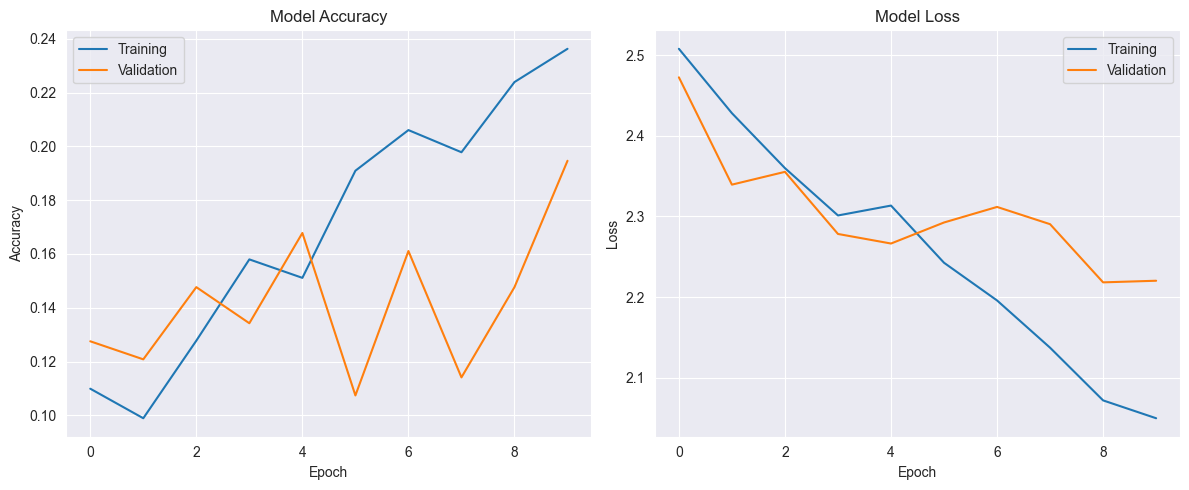

In [237]:
# Plot training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training')
plt.plot(val_acc, label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_3514']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


2024-12-05 13:09:55.680896: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


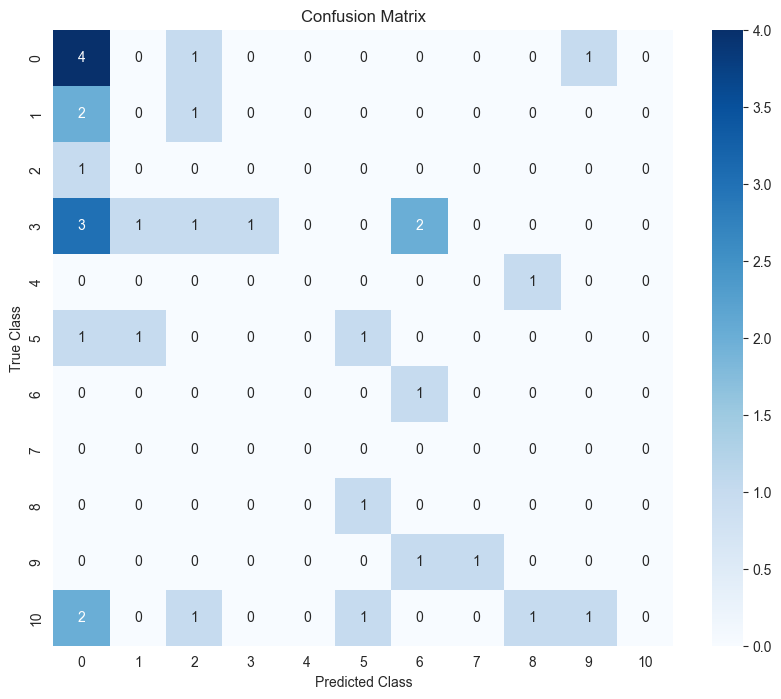


Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.67      0.42         6
           1       0.00      0.00      0.00         3
          10       0.00      0.00      0.00         1
           2       1.00      0.12      0.22         8
           3       0.00      0.00      0.00         1
           4       0.33      0.33      0.33         3
           5       0.25      1.00      0.40         1
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         6

    accuracy                           0.22        32
   macro avg       0.17      0.19      0.13        32
weighted avg       0.35      0.22      0.18        32



/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_

In [238]:
# Evaluate on test set
predictions = []
labels = []

for x, y in test_dataset:
    pred = model.predict(x)
    pred_classes = np.argmax(pred, axis=1)
    predictions.extend(pred_classes)
    labels.extend(y.numpy())

# Create confusion matrix
cm = confusion_matrix(labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

# Print classification report
print('\nClassification Report:')
print(classification_report(labels, predictions, target_names=class_names))

In [240]:
# Save model
model.save('models/colposcopy_model_v2.')
print("Model saved successfully")

Model saved successfully
